#ELEN 6885 Reinforcement Learning Coding Assignment (Part 4)#
There are a lot of official and unofficial tutorials about Tensorflow, and there are also many open-source projects written in Tensorflow. You can refer to those resources according to your interest. In this part of homework 4, only knowledge of Deep Reinforcement Learning and basic programming skills will be needed.

Please put your code into the block marked by\
\############################\
\# YOUR CODE STARTS HERE\
\# YOUR CODE ENDS HERE\
\############################\
Normally you don't need to edit anything outside of the block. If you do want to edit something, please use a similar manner to mark you edits.


In [1]:
import numpy as np
import tensorflow as tf

# DQN
class DQN:
  def __init__(
      self,
      actions_num,
      state_size,
      learning_rate = 0.001,
      gamma = 0.99,
      epsilon_min = 0.05,
      epsilon_start = 0.9,
      replace_target_iter = 300,
      memory_size = 500,
      batch_size = 2,
      epsilon_increment = None,
  ):
      self.actions_num = actions_num
      self.state_size = state_size
      self.lr = learning_rate
      self.gamma = gamma
      self.epsilon_min = epsilon_min
      self.replace_target_iter = replace_target_iter
      self.memory_size = memory_size
      self.batch_size = batch_size
      self.epsilon_increment = epsilon_increment
      self.epsilon = epsilon_start if epsilon_increment is not None else self.epsilon_min
      self.save_model_path = './weights/DQN_model.ckpt'
      self.memory_counter = 0

      # learned steps counter
      self.steps_counter = 0

      # initialize memory [s, a, r, s_, done]
      self.memory = np.zeros((self.memory_size, state_size * 2 + 3))

      # build target_net and q_net
      self.build_net()
      t_params = tf.get_collection('target_net_params')
      q_params = tf.get_collection('q_net_params')
      self.replace_target = [tf.assign(t, q) for t, q in zip(t_params, q_params)]

      # gpu setting
      config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
      config.gpu_options.per_process_gpu_memory_fraction = 0.6
      self.sess = tf.Session(config=config)

      self.sess.run(tf.global_variables_initializer())

  def build_net(self):
    # build q_net
    self.state = tf.placeholder(tf.float32, [None, self.state_size], name='state')
    self.q_target = tf.placeholder(tf.float32, [None, self.actions_num], name='Q_target')
    with tf.variable_scope('q_net'):
      # c_names(collections_names) are the collections to store variables
      c_names, neurons_layer_1, w_initializer, b_initializer = \
        ['q_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 100, \
        tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)

      # layer 1
      with tf.variable_scope('layer_1'):
        w_layer_1 = tf.get_variable('w_layer_1', [self.state_size, neurons_layer_1], initializer=w_initializer, collections=c_names)
        b_layer_1 = tf.get_variable('b_layer_1', [1, neurons_layer_1], initializer=b_initializer, collections=c_names)
        layer_1 = tf.nn.relu(tf.matmul(self.state, w_layer_1) + b_layer_1)

      # layer 2
      with tf.variable_scope('layer_2'):
        w_layer_2 = tf.get_variable('w_layer_2', [neurons_layer_1, self.actions_num], initializer=w_initializer, collections=c_names)
        b_layer_2 = tf.get_variable('b_layer_2', [1, self.actions_num], initializer=b_initializer, collections=c_names)
        self.q_value = tf.matmul(layer_1, w_layer_2) + b_layer_2

    with tf.variable_scope('loss'):
      self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_value))
    with tf.variable_scope('train'):
      self._train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)

    # build target_net
    self.state_t = tf.placeholder(tf.float32, [None, self.state_size], name='state_t')    # input
    with tf.variable_scope('target_net'):
      # c_names(collections_names) are the collections to store variables
      c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

      # layer 1
      with tf.variable_scope('layer_1'):
        w_layer_1 = tf.get_variable('w_layer_1', [self.state_size, neurons_layer_1], initializer=w_initializer, collections=c_names)
        b_layer_1 = tf.get_variable('b_layer_1', [1, neurons_layer_1], initializer=b_initializer, collections=c_names)
        layer_1 = tf.nn.relu(tf.matmul(self.state_t, w_layer_1) + b_layer_1)

      # layer 2

      ############################
      # YOUR CODE STARTS HERE
    
      with tf.variable_scope('layer_2'):
        w_layer_2 = tf.get_variable('w_layer_2', [neurons_layer_1, self.actions_num], initializer=w_initializer, collections=c_names)
        b_layer_2 = tf.get_variable('b_layer_2', [1, self.actions_num], initializer=b_initializer, collections=c_names)
        self.q_next = tf.matmul(layer_1, w_layer_2) + b_layer_2
    
      # YOUR CODE ENDS HERE
      ############################
     
  def store_transition(self, s, a, r, s_, done):
    s=s.reshape(-1)
    s_=s_.reshape(-1)
    transition = np.hstack((s, [a, r], s_, done))

    # replace the old memory with new observations
    index = self.memory_counter % self.memory_size
    self.memory[index, :] = transition

    self.memory_counter += 1

  def choose_action(self, observation):
    # to have batch dimension when fed into tf placeholder
    observation = observation[np.newaxis, :]
    # epsilon-greedy
    if np.random.uniform() > self.epsilon:
      action_values = self.sess.run(self.q_value, feed_dict={self.state: observation})
      action = np.argmax(action_values)
    else:
      action = np.random.randint(0, self.actions_num)
    return action

  def learn(self):
    # replace target parameters every once a while
    if self.steps_counter % self.replace_target_iter == 0:
      self.sess.run(self.replace_target)

    # sample a batch from the memory
    if self.memory_counter > self.memory_size:
      sample_index = np.random.choice(self.memory_size, size=self.batch_size)
    else:
      sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
    batch_memory = self.memory[sample_index, :]

    q_next, q_value = self.sess.run(
      [self.q_next, self.q_value],
      feed_dict={
        self.state_t: batch_memory[:, -self.state_size-1:-1],  # fixed params
        self.state: batch_memory[:, :self.state_size],  # newest params
      })

    # calculate q_target
    q_target = q_value.copy()

    # only change the action-values of this batch, because we only calculate loss on the batch observations
    batch_index = np.arange(self.batch_size, dtype=np.int32)
    act_index = batch_memory[:, self.state_size].astype(int)
    reward = batch_memory[:, self.state_size + 1]
    done = batch_memory[:, -1]
    ############################
    # YOUR CODE STARTS HERE
    
    for batch in batch_index:
      q_target[batch, act_index[batch]] = reward[batch] + (0 if done[batch] else (self.gamma * np.max(q_next[batch,:],axis=0)))
    
    # YOUR CODE ENDS HERE
    ############################
    
    # train q_net
    _, self.cost = self.sess.run([self._train_op, self.loss],
                                  feed_dict={self.state: batch_memory[:, :self.state_size],
                                            self.q_target: q_target})
    # change epsilon
    self.epsilon = self.epsilon - self.epsilon_increment if self.epsilon > self.epsilon_min else self.epsilon_min
    self.steps_counter += 1

  def store(self):
    saver = tf.train.Saver() 
    saver.save(self.sess, self.save_model_path)
  
  def restore(self):
    saver = tf.train.Saver() 
    saver.restore(self.sess, self.save_model_path)






In [2]:
import gym
# cart pole gym environment
env = gym.make("CartPole-v0")
env._max_episode_steps = 500
# state and action space
print(env.action_space)
print(env.observation_space)
# observation
env.reset()
# state, reward, done, info
print(env.step(1))

Discrete(2)
Box(4,)
(array([ 0.01000824,  0.2117136 ,  0.02151308, -0.25150414]), 1.0, False, {})


In [3]:
# play the game and train the network
np.set_printoptions(threshold=np.inf)
episode_length_set = []
tf.reset_default_graph()
total_time_steps = 100000

RL = DQN(actions_num = 2, gamma = 0.99,
         state_size = 4, epsilon_start = 1,
         learning_rate = 1e-3, epsilon_min = 0.01,
         replace_target_iter = 100, memory_size = 5000,
         epsilon_increment = 0.00001,)

new_state = env.reset()
done = False
episode_length_counter = 0
for step in range(total_time_steps):
  ############################
  # YOUR CODE STARTS HERE
    
    if done:
        done = False
        new_state = env.reset()
        episode_length_set.append(episode_length_counter)
        print(step,episode_length_counter)
        episode_length_counter = 0
        continue
    else:
        # take action
        action = RL.choose_action(new_state)
        old_state = new_state
        new_state, reward, done, info = env.step(action)
        RL.store_transition(old_state, action, reward, new_state, done)
    
  # YOUR CODE ENDS HERE
  ############################
  
    if step > 200:
        RL.learn()
    episode_length_counter += 1
    if episode_length_counter == 500:
        RL.store()
# RL.store()

29 29
44 14
89 44
119 29
148 28
160 11
177 16
189 11
203 13
219 15
234 14
300 65
343 42
368 24
381 12
394 12
416 21
428 11
440 11
455 14
478 22
493 14
505 11
537 31
561 23
574 12
596 21
610 13
626 15
643 16
671 27
698 26
716 17
729 12
745 15
760 14
777 16
797 19
812 14
828 15
866 37
897 30
910 12
928 17
938 9
949 10
968 18
985 16
1003 17
1016 12
1039 22
1057 17
1108 50
1128 19
1143 14
1166 22
1183 16
1199 15
1216 16
1240 23
1265 24
1283 17
1304 20
1326 21
1380 53
1408 27
1419 10
1449 29
1464 14
1480 15
1507 26
1528 20
1543 14
1570 26
1591 20
1614 22
1670 55
1690 19
1717 26
1739 21
1785 45
1828 42
1843 14
1856 12
1879 22
1904 24
1916 11
1927 10
1944 16
1966 21
1980 13
1997 16
2008 10
2025 16
2047 21
2063 15
2077 13
2091 13
2114 22
2179 64
2193 13
2225 31
2248 22
2261 12
2305 43
2339 33
2366 26
2385 18
2397 11
2413 15
2426 12
2448 21
2479 30
2499 19
2515 15
2541 25
2558 16
2584 25
2599 14
2609 9
2637 27
2666 28
2712 45
2775 62
2846 70
2859 12
2889 29
2927 37
2942 14
2962 19
3000 37
3020 

31127 145
31203 75
31356 152
31425 68
31524 98
31543 18
31564 20
31661 96
31764 102
31832 67
31909 76
31928 18
32029 100
32048 18
32080 31
32172 91
32214 41
32229 14
32271 41
32418 146
32583 164
32608 24
32652 43
32691 38
32704 12
32748 43
32881 132
32995 113
33148 152
33248 99
33272 23
33328 55
33353 24
33510 156
33528 17
33713 184
33844 130
33867 22
33932 64
34074 141
34105 30
34127 21
34212 84
34282 69
34422 139
34551 128
34596 44
34658 61
34762 103
34826 63
34916 89
34992 75
35018 25
35158 139
35295 136
35344 48
35357 12
35457 99
35531 73
35631 99
35769 137
35866 96
35962 95
36104 141
36169 64
36243 73
36311 67
36373 61
36482 108
36613 130
36688 74
36713 24
36831 117
36904 72
36957 52
37008 50
37120 111
37169 48
37196 26
37236 39
37369 132
37451 81
37475 23
37503 27
37577 73
37646 68
37736 89
37795 58
37826 30
37870 43
37934 63
38011 76
38131 119
38182 50
38254 71
38312 57
38342 29
38368 25
38554 185
38805 250
38945 139
38999 53
39041 41
39086 44
39117 30
39143 25
39164 20
39201 36

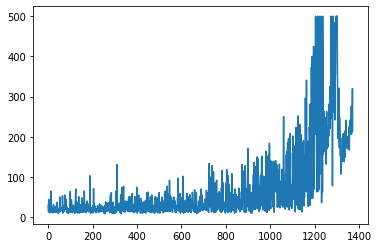

In [5]:
from matplotlib import pyplot as plt
plt.plot(episode_length_set)

In [6]:
# test our network
tf.reset_default_graph()
RL = DQN(actions_num = 2, gamma = 1,
         state_size = 4, epsilon_start = 1,
         learning_rate = 1e-3, epsilon_min = 0,
         replace_target_iter = 100, memory_size = 5000,
         epsilon_increment = None,)
# load saved parameters
RL.restore()
# run 100 trails and print how long can the agent hold the cart pole for each trail
for i in range(100):
  ############################
  # YOUR CODE STARTS HERE
    
  RL.epsilon = 0
  new_state = env.reset()
  done = False
  episode_length_counter = 0
  for step in range(500):
    if(done):
      print(step, episode_length_counter)
      break
    action = RL.choose_action(new_state)
    new_state, reward, done, info = env.step(action)
    episode_length_counter += 1
    if(episode_length_counter == 500):
      print(step, episode_length_counter)
    
  # YOUR CODE ENDS HERE
  ############################
  

INFO:tensorflow:Restoring parameters from ./weights/DQN_model.ckpt
499 500
499 500
499 500
491 491
499 500
424 424
499 500
499 500
499 500
499 500
499 500
499 500
436 436
499 500
499 500
499 500
499 500
416 416
499 500
499 500
370 370
424 424
499 500
499 500
499 500
447 447
499 500
499 500
499 500
499 500
394 394
374 374
499 500
499 500
435 435
499 500
499 500
499 500
499 500
499 500
499 500
457 457
499 500
499 500
499 500
499 500
411 411
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
446 446
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
475 475
499 500
499 500
420 420
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
499 500
465 465
499 500
499 500
499 500
499 500
382 382
483 483
499 500
432 432
499 500


You may find that the episode length doesn't stably improve as more training time is given. You can read chapter 3.2 of this paper https://arxiv.org/pdf/1711.07478.pdf if you are interested.